In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aaih-assignment-3/sample_submission.csv
/kaggle/input/aaih-assignment-3/train.csv
/kaggle/input/aaih-assignment-3/test.csv
/kaggle/input/aaih-assignment-3/test/images/image_4213.png
/kaggle/input/aaih-assignment-3/test/images/image_3470.png
/kaggle/input/aaih-assignment-3/test/images/image_4387.png
/kaggle/input/aaih-assignment-3/test/images/image_3650.png
/kaggle/input/aaih-assignment-3/test/images/image_3312.png
/kaggle/input/aaih-assignment-3/test/images/image_3510.png
/kaggle/input/aaih-assignment-3/test/images/image_4398.png
/kaggle/input/aaih-assignment-3/test/images/image_3738.png
/kaggle/input/aaih-assignment-3/test/images/image_3619.png
/kaggle/input/aaih-assignment-3/test/images/image_3681.png
/kaggle/input/aaih-assignment-3/test/images/image_3448.png
/kaggle/input/aaih-assignment-3/test/images/image_4517.png
/kaggle/input/aaih-assignment-3/test/images/image_4446.png
/kaggle/input/aaih-assignment-3/test/images/image_4550.png
/kaggle/input/aaih-assignment-3/test/

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2 as cv
from PIL import Image

In [37]:

epochs = 30
learning_rate = 0.01
batch_size_train = 16
batch_size_test = 1000
momentum = 0.5
log_interval = 10


random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [38]:
train_path = '/kaggle/input/aaih-assignment-3/train.csv'
df = pd.read_csv(train_path)

# Split dataset
X = df[['id', 'binary_pred']]  # Assuming 'id' is the image identifier and 'binary_pred' is the label
X_train, X_test = train_test_split(X, test_size=0.05, random_state=0)

# Define custom dataset
pathtodownload = '/kaggle/input/aaih-assignment-3/train/images/'


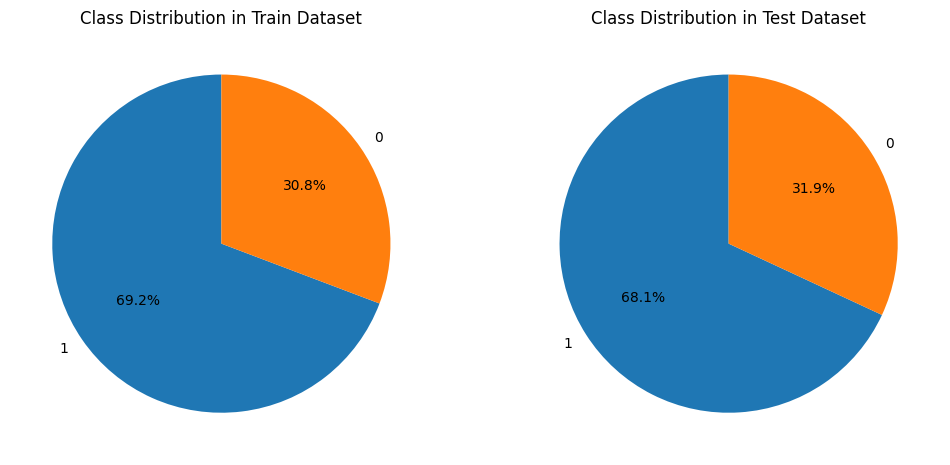

In [47]:

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load CSV data
train_path = '/kaggle/input/aaih-assignment-3/train.csv'
df = pd.read_csv(train_path)


# Count the classes in the train and test datasets
train_class_counts = X_train['binary_pred'].value_counts()
test_class_counts = X_test['binary_pred'].value_counts()

# Create pie charts
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train dataset pie chart
axs[0].pie(train_class_counts, labels=train_class_counts.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Class Distribution in Train Dataset')

# Test dataset pie chart
axs[1].pie(test_class_counts, labels=test_class_counts.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Class Distribution in Test Dataset')

plt.show()


In [39]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)  # Reset index

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if idx >= len(self.df):
            raise IndexError(f"Index {idx} is out of bounds for the DataFrame.")
        
        img_path = pathtodownload + self.df.loc[idx, 'id']
        image = cv.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image at path {img_path} not found.")
        
        label = self.df.loc[idx, 'binary_pred']
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Convert to CxHxW and normalize
        label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return image, label 

train_dataset = CustomDataset(X_train)
test_dataset = CustomDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the network and optimizer
network = models.resnet18().to(device)  # Move the model to GPU
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)


Using device: cuda


In [40]:
examples=next(iter(train_loader))
print(examples[0].size,examples[1].size)

<built-in method size of Tensor object at 0x7c3811674ef0> <built-in method size of Tensor object at 0x7c3811674f40>


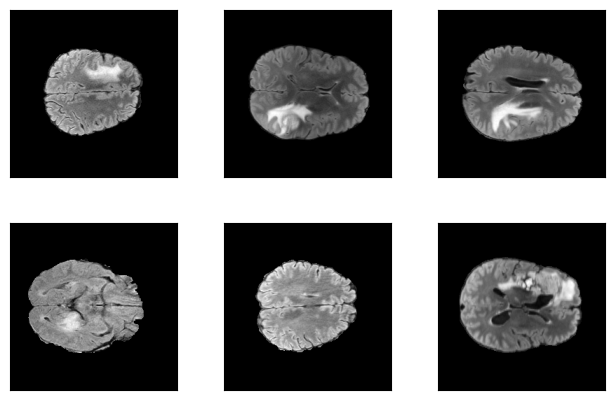

In [41]:
import matplotlib.pyplot as plt 

fig= plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(examples[0][i][0],cmap="gray",interpolation=None)
    plt.xticks([])
    plt.yticks([])

In [42]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(epochs + 1)]

In [43]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data and target to GPU
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * batch_size_train) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), 'results.pt')
            torch.save(optimizer.state_dict(), 'optimizer.pt')


In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data and target to GPU
            output = network(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
        
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_targets


In [45]:
test()
for epoch in range(1,epochs+1):
    train(epoch)
    test()
    

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -0.0340, Accuracy: 0/166 (0%)

Train Epoch: 1 [0/3144 (0%)]	Loss: 7.148709
Train Epoch: 1 [160/3144 (5%)]	Loss: 0.613199
Train Epoch: 1 [320/3144 (10%)]	Loss: 0.580828
Train Epoch: 1 [480/3144 (15%)]	Loss: 0.595936
Train Epoch: 1 [640/3144 (20%)]	Loss: 0.251269
Train Epoch: 1 [800/3144 (25%)]	Loss: 0.184662
Train Epoch: 1 [960/3144 (30%)]	Loss: 0.676249
Train Epoch: 1 [1120/3144 (36%)]	Loss: 0.286163
Train Epoch: 1 [1280/3144 (41%)]	Loss: 0.333184
Train Epoch: 1 [1440/3144 (46%)]	Loss: 0.615770
Train Epoch: 1 [1600/3144 (51%)]	Loss: 0.597797
Train Epoch: 1 [1760/3144 (56%)]	Loss: 0.263383
Train Epoch: 1 [1920/3144 (61%)]	Loss: 0.228959
Train Epoch: 1 [2080/3144 (66%)]	Loss: 0.222718
Train Epoch: 1 [2240/3144 (71%)]	Loss: 0.706149
Train Epoch: 1 [2400/3144 (76%)]	Loss: 0.125153
Train Epoch: 1 [2560/3144 (81%)]	Loss: 0.384732
Train Epoch: 1 [2720/3144 (86%)]	Loss: 0.163588
Train Epoch: 1 [2880/3144 (91%)]	Loss: 0.315291
Train Epoch: 1 [3040/3144 (96%)]	Loss: 0.20433


Test set: Avg. loss: -20.9616, Accuracy: 164/166 (99%)

Precision: 0.9912
Recall: 0.9912
F1 Score: 0.9912


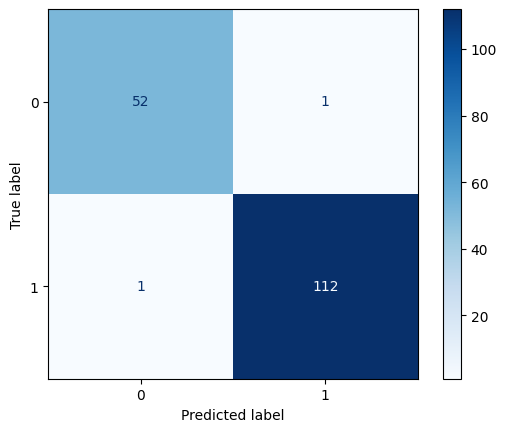

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
all_preds, all_targets = test()
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()